In [44]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow_addons as tfa


In [45]:
df = pd.read_csv('../data/pre-processed.csv')
df = df.drop(columns=['index'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [46]:
df['label'] = df.apply(lambda row: 1 if row.label == 'fake' else 0, axis=1)
X = df.drop(['label'], axis = 1)
Y = df['label']

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5, stratify=Y)

X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index


In [49]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
test_sequences = train_tokenizer.texts_to_sequences(X_test)

print(f'Vocab length {vocab_length}, Train sequences {len(train_sequences)}, Test sequences {len(test_sequences)} ')

Vocab length 72906, Train sequences 5760, Test sequences 1440 


In [50]:
maxlen=40
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [51]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(72906, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(4, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(3, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(3, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 6)             437436    
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 4)             44        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40, 3)             24        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 3)                 21        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 24)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [54]:
history = model.fit(train_padded_seqeunces, y_train, epochs=10)

Epoch 1/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0215 - accuracy: 0.9906
Epoch 2/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0187 - accuracy: 0.9911
Epoch 3/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0163 - accuracy: 0.9917
Epoch 4/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0190 - accuracy: 0.9899
Epoch 5/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0193 - accuracy: 0.9880
Epoch 6/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0173 - accuracy: 0.9910
Epoch 7/10
180/180 [==============================] - 2s 12ms/step - loss: 0.0165 - accuracy: 0.9908
Epoch 8/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0223 - accuracy: 0.9891
Epoch 9/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0186 - accuracy: 0.9908
Epoch 10/10
180/180 [==============================] - 2s 11ms/step - loss: 0.0172 - accura

45/45 [==============================] - 0s 4ms/step


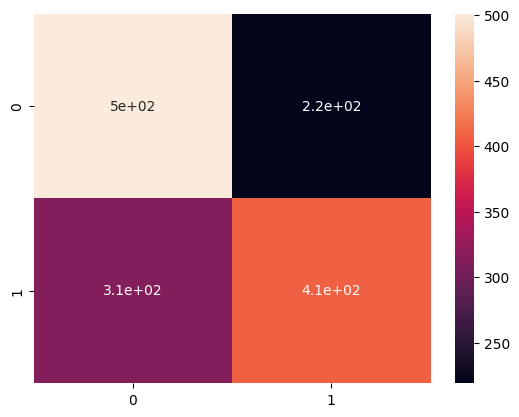

In [53]:
from sklearn.metrics import confusion_matrix
y_train_pred = model.predict(test_padded_seqeunces)
y_train_pred = (y_train_pred > 0.75)
cm = confusion_matrix(y_test, y_train_pred)
sns.heatmap(cm, annot=True)

5566    False
991      True
5725    False
1847     True
3674    False
        ...  
2389     True
5890    False
1204     True
2105     True
3714    False
Name: label, Length: 1440, dtype: bool